AnomalyCLIP
======

 **AnomalyCLIP: Object-agnostic Prompt Learning for Zero-shot Anomaly Detection**

* Paper: https://arxiv.org/pdf/2310.18961

![AnomalyCLIP overview](../assets/anomalyclip_overview.png)

```bash
git clone https://github.com/zqhang/AnomalyCLIP.git AnomalyCLIP_repo

conda create --name anomalyclip python=3.10 -y
conda activate anomalyclip

pip install -r AnomalyCLIP_repo/requirements.txt 
pip install thop ftfy regex tabulate opencv-python

pip install "numpy<2"
```

In [1]:
import os
import sys
import random
import argparse

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from tabulate import tabulate
from scipy.ndimage import gaussian_filter

sys.path.append("AnomalyCLIP_repo")
import AnomalyCLIP_lib
from prompt_ensemble import AnomalyCLIP_PromptLearner
from loss import FocalLoss, BinaryDiceLoss
from utils import normalize
from dataset import Dataset
from logger import get_logger
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from visualization import visualizer
from metrics import image_level_metrics, pixel_level_metrics


/home/pyml/anaconda3/envs/anomalyclip/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_ctx = 12
depth = 9
t_n_ctx = 4
image_size = 518
features_list = [6, 12, 18, 24]
feature_map_layer = [0, 1, 2, 3]
checkpoint_path = (
    "AnomalyCLIP_repo/checkpoints/"
    "9_12_4_multiscale/epoch_15.pth"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AnomalyCLIP_parameters = {
    "Prompt_length": n_ctx,
    "learnabel_text_embedding_depth": depth,
    "learnabel_text_embedding_length": t_n_ctx
}

model, _ = AnomalyCLIP_lib.load(
    "ViT-L/14@336px",
    device=device,
    design_details=AnomalyCLIP_parameters
)
model.eval();


name ViT-L/14@336px
text_layer False
text_layer True


In [3]:
prompt_learner = AnomalyCLIP_PromptLearner(
    model.to("cpu"), AnomalyCLIP_parameters
)
checkpoint = torch.load(checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer=20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(
    cls_id=None
)
text_features = model.encode_text_learn(
    prompts,
    tokenized_prompts,
    compound_prompts_text
).float()
text_features = torch.stack(
    torch.chunk(text_features, dim=0, chunks=2),
    dim=1
)
text_features /= text_features.norm(dim=-1, keepdim=True)

Initializing class-specific contexts
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
single_para torch.Size([4, 768])
embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


In [4]:
import torchvision.transforms as transforms
from AnomalyCLIP_lib.transform import image_transform
from AnomalyCLIP_lib.constants import (
    OPENAI_DATASET_MEAN, OPENAI_DATASET_STD
)

def get_transform(image_size,):
    preprocess = image_transform(
        image_size,
        is_train=False,
        mean=OPENAI_DATASET_MEAN,
        std=OPENAI_DATASET_STD
    )
    target_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    preprocess.transforms[0] = transforms.Resize(
        size=(image_size, image_size),
        interpolation=transforms.InterpolationMode.BICUBIC,
        max_size=None,
        antialias=None
    )
    preprocess.transforms[1] = transforms.CenterCrop(
        size=(image_size, image_size)
    )
    return preprocess, target_transform


rgb_transform, mask_transform = get_transform(image_size)
print(rgb_transform)
print(mask_transform)

Compose(
    Resize(size=(518, 518), interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(518, 518))
    <function _convert_to_rgb at 0x7f1135edd120>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Compose(
    Resize(size=(518, 518), interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(518, 518))
    ToTensor()
)


(1008, 756)


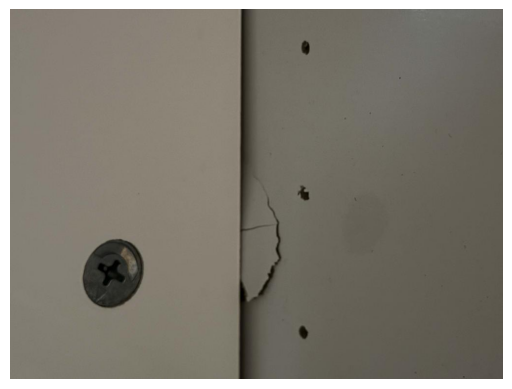

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "furniture_damage.jpg"
image = Image.open(image_path).convert("RGB")
print(image.size)
plt.imshow(image)
plt.axis("off")
plt.show()